# 컴퓨터 비전을 위한 딥러닝(Deeplearning for Computer Vision)

* 이 장에서는 컨브넷(convnet)이라고도 불리는 합성곱 신경망(convolutional neural network)을 소개합니다. 이 딥러닝 모델은 거의 대부분의 컴퓨터 비전(computer vision) 애플리케이션에 사용됩니다. 거대 IT 회사가 아니라면 대부분 작은 데이터셋을 다루므로 여기에서도 작은 훈련 데이터셋을 사용한 이미지 분류 문제에 컨브넷을 적용하는 법을 배우겠습니다.

## 5.1 합성곱 신경망 소개

* 컨브넷의 정의와 컨브넷이 컴퓨터 비전 관련 작업에 잘 맞는 이유에 대해 이론적 배경을 알아보겠습니다. 하지만 먼저 간단한 컨브넷 예제를 둘러 보죠. 2장에서 완전 연결 네트워크로 풀었던(이 방식의 테스트 정확도는 97.8%였습니다) MNIST 숫자 이미지 분류에 컨브넷을 사용해 보겠습니다. 기본적인 컨브넷이더라도 2장의 완전 연결된 모델의 성능을 훨씬 앞지를 것입니다.

* 다음 코드는 기본적인 컨브넷의 모습입니다. Conv2D와 MaxPooling2D 층을 쌓아 올렸습니다. 잠시 후에 이들이 무엇인지 배우겠습니다.

* 컨브넷이 (image_height, image_width, image_channels) 크기의 입력 텐서를 사용한다는 점이 중요합니다(배치 차원은 포함하지 않습니다). 이 예제에서는 MNIST 이미지 포맷인 (28, 28, 1) 크기의 입력을 처리하도록 컨브넷을 설정해야 합니다. 이 때문에 첫 번째 층의 매개변수로 input_shape=(28, 28, 1)을 전달합니다.

In [5]:
# 간단한 컨브넷 만들기(Create a simple convnet)
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [7]:
# 컨브넷 위에 분류기 추가하기(adding a classifier on the convnet)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

* 10개의 클래스를 분류하기 위해 마지막 층의 출력 크기를 10으로 하고 소프트맥스 활성화 함수를 사용합니다. 이제 전체 네트워크는 다음과 같습니다.

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [9]:
# MNIST 이미지에 컨브넷 훈련하기(train convnet to MNIST images)
from keras.datasets import mnist
from keras.utils import to_categorical
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels,epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 66s 69ms/step - loss: 0.3951 - accuracy: 0.8718
Epoch 2/5
938/938 [==============================] - 65s 69ms/step - loss: 0.0493 - accuracy: 0.9841
Epoch 3/5
938/938 [==============================] - 64s 69ms/step - loss: 0.0324 - accuracy: 0.9904
Epoch 4/5
938/938 [==============================] - 69s 74ms/step - loss: 0.0257 - accuracy: 0.9925
Epoch 5/5
938/938 [==============================] - 65s 70ms/step - loss: 0.0164 - accuracy: 0.9949


In [10]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

313/313 [==============================] - 4s 11ms/step - loss: 0.0301 - accuracy: 0.9917
0.9916999936103821


### 5.1.1 합성곱 연산
* 완전 연결 층과 합성곱 층 사이의 근본적인 차이는 다음과 같습니다. Dense 층은 입력 틀성 공간에 있는 전역 패턴(예를 들어 MNIST 숫자 이미지에서는 모든 픽셀에 걸친 패턴)을 학습하지만 합성곱 층은 지역 패턴을 학습합니다. 이미지의 경우 작은 2D 윈도우(window)로 입력에서 패턴을 찾습니다. 앞의 예에서 이 윈도우는 모두 3X3 크기였습니다.
* 이 핵심 특징은 컨브넷에 두 가지 흥미로운 성질을 제공합니다.
    * 학습된 패턴은 평행 이동 불변성(translation invariant)을 가집니다. 컨브넷이 이미지의 오른쪽 아래 모서리에서 어떤 패턴을 학습했다면 다른 곳(예를 들어 왼쪽 위 모서리)에서도 이 패턴을 인식할 수 있습니다. 완전 연결 네트워크는 새로운 위치에 나타난 것은 새로운 패턴으로 학습해야 합니다. 이런 성질은 컨브넷이 이미지를 효율적으로 처리하게 만들어 줍니다(근본적으로 우리가 보는 세상은 평행 이동으로 인해 다르게 인식되지 않습니다). 적은 수의 훈련 샘플을 사용해서 일반화 능력을 가진 표현을 학습할 수 있습니다.
    
    * 컨브넷(convnet)은 패턴의 공간적 계층 구조를 학습할 수 있습니다. 첫 번째 합성곱 층에 에지 같은 작은 지역 패턴을 학습합니다. 두 번째 합성곱 층은 첫 번째 층의 특성으로 구성된 더 큰 패턴을 학습하는 식입니다. 이런 방식을 사용하여 컨브넷은 매우 복잡하고 추상적인 시각적 개념을 효과적으로 학습할 수 있습니다(근본적으로 우리가 보는 세성은 공간적 계층 구조를 가집니다).
    
### 5.1.2 최대 풀링 연산(Maximum Pooling Operation)
* 앞선 컨브넷 예제에서 특성 맵의 크기가 MaxPooling2D 층마다 절반으로 줄어들었습니다. 예를 들어 첫 번째 MaxPooling2D 층 이전에 특성 맵의 크기는 26 X 26 이었는데 최대 풀링 연산으로 13 X 13으로 줄어들었습니다. 스트라이드 합성곱과 매우 비슷하게 강제적으로 특성 맵을 다운심플링 하는 것이 최대 풀링의 역할입니다.
* 최대 풀링은 입력 특성 맵에서 윈도우를 맞는 패치를 추출하고 각 채널별로 최댓값을 출력합니다. 합성곱과 개념적으로 비슷하지만 추출한 패치에 학습된 선형 변환(합성곱 커널(Convolutional Kernel))을 적용하는 대신 하드코딩된 최댓값 추출 연산을 사용합니다. 합성곱과 가장 큰 차이점은 최대 풀링은 보통 2 X 2 윈도우와 스트라이드 2를 사용하여 특성 맵을 절반 크기로 다운샘플링한다는 것입니다. 이에 반해 합성곱은 전형적으로 3 X 3 윈도우와  스트라이드 1을 사용합니다.
* 왜 이런 식으로 특성 맵을 다운샘플링할까요? 왜 최대 풀링 층을 빼고 큰 특성 맵을 계속 유지하지 않을까요? 이런 방식을 한번 테스트해보죠. 합성곱으로만 이루어진 모델은 다음과 같습니다.

In [11]:
model_no_max_pool = models.Sequential()
model_no_max_pool.add(layers.Conv2D(32, (3, 3), activation='relu',
                      input_shape=(28, 28, 1)))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))

* 모델의 구조는 다음과 같습니다.

In [12]:
model_no_max_pool.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 64)        36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


※ 이 설정이 무엇이 문제일까요? 두 가지가 있습니다.
* 특성의 공간적 계층 구조를 학습하는 데 도움이 되지 않습니다. 세 번째 층의 3 X 3 윈도우는 초기 입력의 7 X 7 윈도우 영역에 대한 정보만 담고 있습니다. 컨브넷에 의해 학습된 고수준 패턴은 초기 입력에 관한 정보가 아주 적어 숫자 분류를 학습하기에 충분하지 않을 것입니다(7X7픽셀 크기의 창으로 숫자를 보고 분류해 보세요!). 마지막 합성곱 층의 특성이 전체 입력에 대한 정보를 가지고 있어야 합니다.
* 최종 특성 맵은 22 X 22 X 64 = 30,976개의 원소를 가집니다. 아주 많습니다. 이 컨브넷(convnet)을 펼친 후 512크기의 Dense 층과 연결한다면 약 15.8백만 개의 가중치 파라미터가 생깁니다. 작은 모델치고는 너무 많은 가중치고, 심각한 과대적합이 발생할 것입니다.

## 5.2 소규모 데이터셋에서 밑바닥부터 컨브넷 훈련하기(Training convnets with small datasets)


### 5.2.2 데이터 내려받기
* 여기서 사용할 강아지 vs. 고양이 데이터셋(Dogs vs. Cats dataset)은 케라스에 포함되어 있지 않습니다. 컨브넷이 주류가 되기 전인 2013년 후반에 캐글에서 컴퓨터 비전 경연 대회의 일환으로 이 데이터셋을 만들었습니다. 원본 데이터셋을 https://www.kaggle.com/c/dogs-vs-cats/data 에서 내려받을 수 있습니다(캐글(kaggle) 계정이 없다면 하나 만들어야 하지만 계정을 만드는 과정은 간단합니다).
* 이 사진들은 중간 정도의 해상도를 가진 컬러 **JPEG** 파일입니다. 다음이 몇 개 샘플입니다.

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)
[강아지 vs 고양이 데이터셋의 샘플로 이 샘플들은 원본 크기 그대로이며, 샘플들은 사이즈와 모습 등이 제각각이다.]

* 당연히 2013년 강아지 vs 고양이 캐글(kaggle) 경연은 컨브넷을 사용한 참가자가 우승하였습니다. 최고 성능은 95%의 정확도를 달성했습니다. 이 예제를 가지고 (다음 절에서) 참가자들이 사용했던 데이터의 10%보다 적은 양으로 모델을 훈련하고도 이와 아주 근접한 정확도를 달성해 보겠습니다.

* 이 데이터셋은 25,000개의 강아지와 고양이 이미지(클래스마다 12,500개)를 담고 있고 (압축해서) 543MB 크기입니다. 다운로드하고 압축을 해제한 후 3개의 서브셋이 들어 있는 새로운 데이터셋을 만들 것입니다. 클래스마다 1,000개의 샘플로 이루어진 훈련 세트, 클래스마다 500개의 샘플로 이루어진 검증 세트, 클래스마다 500개의 샘플로 이루어진 테스트 세트입니다.
* 다음은 이를 처리하는 코드입니다.

In [1]:
# 훈련, 검증, 테스트 폴더로 이미지 복사하기(copy image to train, validation, and test folder)
import os, shutil

In [3]:
# 원본 데이터셋을 압축 해제한 디렉터리 경로
original_dataset_dir = '../data/cats_and_dogs/train'

# 소규모 데이터셋을 저장할 디렉터리
base_dir = '../data/cats_and_dogs_small'
if os.path.exists(base_dir):  # 반복적인 실행을 위해 디렉토리를 삭제합니다.
    shutil.rmtree(base_dir)   # 이 코드는 책에 포함되어 있지 않습니다.
os.mkdir(base_dir)

# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 다음 500개 고양이 이미지를 validation_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 고양이 이미지를 test_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 처음 1,000개의 강아지 이미지를 train_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 validation_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 test_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

* 복사가 잘 되었는지 확인하기 위해 각 분할(훈련/검증/테스트)에 들어 있는 사진의 개수를 카운트해 보죠.

In [4]:
print('훈련용 고양이 이미지 전체 개수:', len(os.listdir(train_cats_dir)))

훈련용 고양이 이미지 전체 개수: 1000


In [5]:
print('훈련용 강아지 이미지 전체 개수:', len(os.listdir(train_dogs_dir)))

훈련용 강아지 이미지 전체 개수: 1000


In [6]:
print('검증용 고양이 이미지 전체 개수:', len(os.listdir(validation_cats_dir)))

검증용 고양이 이미지 전체 개수: 500


In [7]:
print('검증용 강아지 이미지 전체 개수:', len(os.listdir(validation_dogs_dir)))

검증용 강아지 이미지 전체 개수: 500


In [8]:
print('테스트용 고양이 이미지 전체 개수:', len(os.listdir(test_cats_dir)))

테스트용 고양이 이미지 전체 개수: 500


In [9]:
print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_dogs_dir)))

테스트용 강아지 이미지 전체 개수: 500


* 이제 2,000개의 훈련 이미지, 1,000개의 검증 이미지, 1,000개의 테스트 이미지가 준비되었습니다. 분할된 각 데이터는 클래마다 동일한 개수의 샘플을 포함합니다. 균형잡힌 이진 분류 문제이므로 정확도를 사용해 성공을 측정하겠습니다.

### 5.2.3 네트워크 구성하기

이전 예제에서 MNIST를 위해 간단한 컨브넷을 만들었습니다. 이제 컨브넷에 친숙해졌을 것입니다. 여기서 사용할 구조도 일반적으로 동일합니다. `Conv2D`(`relu` 활성화 함수 사용)와 `MaxPooling2D` 층을 번갈아 쌓은 컨브넷을 만들겠습니다.

이전보다 이미지가 크고 복잡한 문제이기 때문에 네트워크를 좀 더 크게 만들겠습니다. `Conv2D` + `MaxPooling2D` 단계를 하나 더 추가합니다. 이렇게 하면 네트워크의 용량을 늘리고 `Flatten` 층의 크기가 너무 커지지 않도록 특성 맵의 크기를 줄일 수 있습니다. 150 × 150 크기(임의로 선택한 것입니다)의 입력으로 시작해서 `Flatten` 층 이전에 7 × 7 크기의 특성 맵으로 줄어듭니다.

특성 맵의 깊이는 네트워크에서 점진적으로 증가하지만(32에서 128까지), 특성 맵의 크기는 감소합니다(150 × 150에서 7 × 7까지). 이는 거의 모든 컨브넷에서 볼 수 있는 전형적인 패턴입니다.

이진 분류 문제이므로 네트워크는 하나의 유닛(크기가 1인 `Dense` 층)과 `sigmoid` 활성화 함수로 끝납니다. 이 유닛은 한 클래스에 대한 확률을 인코딩할 것입니다.

In [10]:
# 강아지 vs 고양이 분류를 위한 소규모 컨브넷 만들기
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

* 층들을 거치면서 특성 맵의 차원이 어떻게 변했는지 살펴보겠습니다.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

* 컴파일 단계에서 이전과 같이 RMSprop 옵티마이저를 선택하겠습니다. 네트워크의 마지막이 하나의 시그모이드 유닛이기 때문에 이진 크로스엔트로피(binary crossentropy)를 손실로 사용합니다(4장 5절에서 다양한 경우에 사용할 수 있는 손실 함수 목록을 볼 수 있습니다).

In [12]:
# 모델의 훈련 설정하기
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### 5.2.4 데이터 전처리

데이터는 네트워크에 주입되기 전에 부동 소수 타입의 텐서로 적절하게 전처리되어 있어야 합니다. 지금은 데이터가 JPEG 파일로 되어 있으므로 네트워크에 주입하려면 대략 다음 과정을 따릅니다.

1.	사진 파일을 읽습니다.
2.	JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩합니다.
3.	그다음 부동 소수 타입의 텐서로 변환합니다.
4.	픽셀 값(0에서 255 사이)의 스케일을 [0, 1] 사이로 조정합니다(신경망은 작은 입력 값을 선호합니다).

좀 복잡하게 보일 수 있지만 다행히 케라스는 이런 단계를 자동으로 처리하는 유틸리티를 가지고 있습니다. 케라스는 `keras.preprocessing.image`에 이미지 처리를 위한 헬퍼 도구들을 가지고 있습니다. 특히 `ImageDataGenerator` 클래스는 디스크에 있는 이미지 파일을 전처리된 배치 텐서로 자동으로 바꾸어주는 파이썬 제너레이터를 만들어 줍니다. 이 클래스를 사용해 보겠습니다.

In [13]:
# ImageDataGenerator를 사용하여 디렉터리에서 이미지 읽기
# (Reading Image from a directory by using ImageDataGenerator)
from keras.preprocessing.image import ImageDataGenerator

# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


* 이 제너레이터의 출력 하나를 살펴보죠. 이 출력은 150 × 150 RGB 이미지의 배치((20, 150, 150, 3) 크기)와 이진 레이블의 배치((20,) 크기)입니다. 각 배치에는 20개의 샘플(배치 크기)이 있습니다. 제너레이터는 이 배치를 무한정 만들어 냅니다. 타깃 폴더에 있는 이미지를 끝없이 반복합니다. 따라서 반복 루프안의 어디에선가 break 문을 사용해야 합니다.

In [14]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20,)


* 제너레이터를 사용한 데이터에 모델을 훈련시켜 보겠습니다. fit_generator 메서드는 fit 메서드와 동일하되 데이터 제너레이터를 사용할 수 있습니다. 이 메서드는 첫 번째 매개변수로 입력과 타깃의 배치를 끝없이 반환하는 파이썬 제너레이터를 기대합니다. 데이터가 끝없이 생성되기 때문에 케라스 모델에 하나의 에포크를 정의하기 위해 제너레이터로부터 얼마나 많은 샘플을 뽑을 것인지 알려 주어야 합니다. steps_per_epoch 매개변수에서 이를 설정합니다. 제너레이터로부터 steps_per_epoch 개의 배치만큼 뽑은 다음, 즉 steps_per_epoch 횟수만큼 경사 하강법 단계를 실행한 다음에 훈련 프로세스는 다음 에포크로 넘어갑니다. 여기서는 20개의 샘플이 하나의 배치이므로 2,000개의 샘플을 모두 처리할 때까지 100개의 배치를 뽑을 것입니다.

* fit_generator를 사용할 때 fit 메서드와 마찬가지로 validation_data 매개변수를 전달할 수 있습니다. 이 매개변수에는 데이터 제너레이터도 가능하지만 넘파이 배열의 튜플도 가능합니다. validation_data로 제너레이터를 전달하면 검증 데이터의 배치를 끝없이 반환합니다. 따라서 검증 데이터 제너레이터에서 얼마나 많은 배치를 추출하여 평가할지 validation_steps 매개변수에 지정해야 합니다.

In [26]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

C:\Users\wnstj\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 147s 1s/step - loss: 0.7044 - acc: 0.5070 - val_loss: 0.6696 - val_acc: 0.6110
Epoch 2/30
100/100 [==============================] - 157s 2s/step - loss: 0.6606 - acc: 0.6169 - val_loss: 0.7048 - val_acc: 0.5350
Epoch 3/30
100/100 [==============================] - 154s 2s/step - loss: 0.6370 - acc: 0.6439 - val_loss: 0.6535 - val_acc: 0.5880
Epoch 4/30
100/100 [==============================] - 207s 2s/step - loss: 0.5805 - acc: 0.7013 - val_loss: 0.5928 - val_acc: 0.6700
Epoch 5/30
100/100 [==============================] - ETA: 0s - loss: 0.5417 - acc: 0.7202

KeyboardInterrupt: 

* 훈련이 끝나면 항상 모델을 저장하는 것이 좋은 습관입니다.

In [32]:
model.save('cats_and_dogs_small_1.h5')

* 훈련 데이터와 검증 데이터에 대한 모델의 손실도와 정확도를 그래프로 나타내 보겠습니다.

In [15]:
import matplotlib.pyplot as plt

In [23]:
# 훈련의 정확도와 손실 그래프 그리기
# Draw training accuracy and loss graphs
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

* 이 그래프는 과대적합의 특성을 보여줍니다. 훈련 정확도가 시간이 지남에 따라 선형적으로 증가해서 거의 100%에 도달합니다. 반면 검증 정확도는 70-72%에서 멈추었습니다. 검증 손실은 다섯 번의 에포크만에 최솟값에 다다른 이후에 더 이상 진전되지 않았습니다. 반면 훈련 손실은 거의 0에 도달할 때까지 선형적으로 계속 감소합니다.

* 비교적 훈련 샘플의 수(2,000개)가 적기 때문에 과대적합이 가장 중요한 문제입니다. 드롭아웃이나 가중치 감소(L2 규제)와 같은 과대적합을 감소시킬 수 있는 여러 가지 기법들을 배웠습니다. 여기에서는 컴퓨터 비전에 특화되어 있어서 딥러닝으로 이미지를 다룰 때 매우 일반적으로 사용되는 새로운 방법인 데이터 증식을 시도해 보겠습니다.

### 5.2.5 데이터 증식 사용하기
* 과대적합은 학습할 샘플이 너무 적어 새로운 데이터에 일반화할 수 있는 모델을 훈련시킬 수 없기 때문에 발생합니다. 무한히 많은 데이터가 주어지면 데이터 분포의 모든 가능한 측면을 모델이 학습할 수 있을 것입니다. 데이터 증식은 기존의 훈련 샘플로부터 더 많은 훈련 데이터를 생성하는 방법입니다. 이 방법은 그럴듯한 이미지를 생성하도록 여러 가지 랜덤한 변환을 적용하여 샘플을 늘립니다. 훈련 시에 모델이 정확히 같은 데이터를 두 번 만나지 않도록 하는 것이 목표입니다. 모델이 데이터의 여러 측면을 학습하면 일반화에 도움이 될 것입니다.

* 케라스에서는 `ImageDataGenerator`가 읽은 이미지에 여러 종류의 랜덤 변환을 적용하도록 설정할 수 있습니다. 예제를 먼저 만들어보죠.

In [16]:
from keras.preprocessing.image import ImageDataGenerator
# ImageDataGenerator를 사용하여 데이터 증식 설정하기
# setting up data augmentation by using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

※ 추가적인 매개변수가 몇 개 더 있습니다(케라스 문서를 참고하세요). 이 코드를 간단히 살펴보죠.

* `rotation_range`는 랜덤하게 사진을 회전시킬 각도 범위입니다(0-180 사이).
* `width_shift_range`와 `height_shift_range`는 사진을 수평과 수직으로 랜덤하게 평행 이동시킬 범위입니다(전체 넓이와 높이에 대한 비율).
* `shear_range`는 랜덤하게 전단 변환을 적용할 각도 범위입니다.
* `zoom_range`는 랜덤하게 사진을 확대할 범위입니다.
* `horizontal_flip`은 랜덤하게 이미지를 수평으로 뒤집습니다. 수평 대칭을 가정할 수 있을 때 사용합니다(예를 들어, 풍경/인물 사진).
* `fill_mode`는 회전이나 가로/세로 이동으로 인해 새롭게 생성해야 할 픽셀을 채울 전략입니다.

증식된 이미지 샘플을 살펴보죠.

../data/cats_and_dogs_small\train\cats\cat.100.jpg


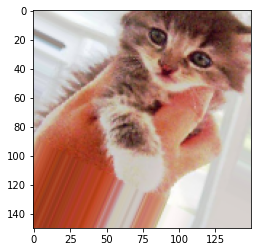

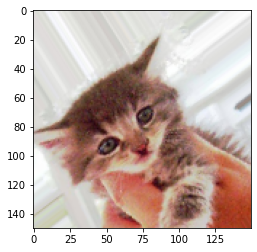

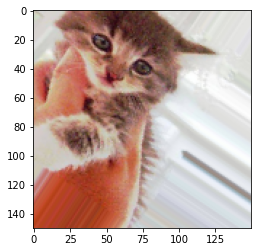

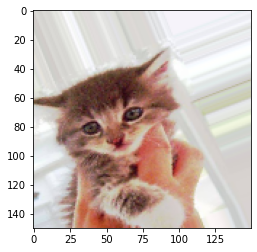

In [20]:
# 랜덤하게 증식된 훈련 이미지 그리기
# Draw randomly augmented training images
from keras.preprocessing import image
fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])
print(fnames[3])
# 증식할 이미지 선택합니다
img_path = fnames[3]

# 이미지를 읽고 크기를 변경합니다
img = image.load_img(img_path, target_size=(150, 150))

# (150, 150, 3) 크기의 넘파이 배열로 변환합니다
x = image.img_to_array(img)

# (1, 150, 150, 3) 크기로 변환합니다
x = x.reshape((1,) + x.shape)

# flow() 메서드는 랜덤하게 변환된 이미지의 배치를 생성합니다.
# 무한 반복되기 때문에 어느 지점에서 중지해야 합니다!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [ ]:
[foseja]